# Learning and Decision Making

## Laboratory 4: Supervised learning

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. The LFW dataset

The LFW (Labeled Faces in the Wild) data set is a collection of JPEG pictures of famous people collected over the internet. Each picture is centered on a single face and corresponds to a grayscale image of 62 $\times$ 47 pixels. 

---

We start by loading the dataset, selecting only those people in the dataset that appear in at least 50 pictures.

<IPython.core.display.Javascript object>


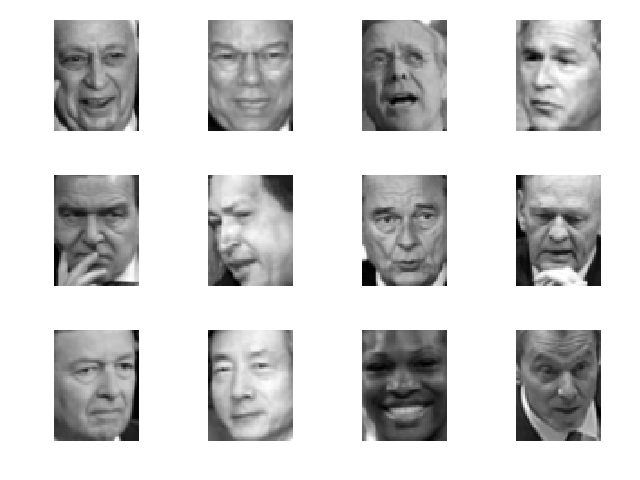

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn import datasets

# Load dataset
lfw = datasets.fetch_lfw_people(min_faces_per_person=50)

fig = plt.figure()

# Print sample digits
for i in range(12): 
    plt.subplot(3, 4, i + 1)
    idx=list(lfw.target).index(i)
    plt.imshow(lfw.images[idx], cmap=plt.cm.gray)
    plt.axis('off')

fig.tight_layout()
plt.show()

In the first activities, you will prepare the dataset, before running the learning algorithm.

---

#### Activity 1.        

From the LFW dataset, construct the training and test sets. The input data can be accessed as the attribute `data` in the dataset `lfw`; the corresponding output data can be accessed as the attribute `target` in `lfw`. To build the train and test sets, you can use the function `train_test_split` from the module `model_selection` of `scikit-learn`. Make sure that the test set corresponds to 10% of your data. 

**Note:** Don't forget to import `numpy` and the necessary modules from `scikit-learn`. Also, for reproducibility, initialize the seed of the `train_test_split` function to a fixed number.

---

In [3]:
from sklearn import model_selection
import numpy as np

train, test, train_target, test_target = model_selection.train_test_split(lfw.data, lfw.target, test_size = 0.1, train_size = 0.9, random_state = 4)
print('Test size (10%):' + str(test.shape[0]) + '\nTrain size (90%):' + str(train.shape[0]))
print('Test_target size (10%):' + str(test_target.shape[0]) + '\nTrain_target size (90%):' + str(train_target.shape[0]))

Test size (10%):156
Train size (90%):1404
Test_target size (10%):156
Train_target size (90%):1404


Right now, each point in the dataset is represented by the pixel information, which roughly corresponds to 3,000 features. In this activity, you will determine a small number of alternative features that manage to capture most of the relevant information contained in each picture but which provide a much more compact representation thereto. Such features correspond to the _principal components_ and can be computed through the function `PCA`, in the `decomposition` module of `scikit-learn`. 

---

#### Activity 2.        

* Run PCA on the training set. To do this, you should first fit the PCA model to the data and then use the resulting model to transform the data. For details, check the documentation for the function `PCA`.

* To grasp how much of the information in the data is contained in the different components, plot the _cumulative explained variance_ (in percentage) as a function of the number of components. The explained variance can be accessed via the attribute `explained_variance_` of your model.

**Note:** In general, before running PCA on some training set, you should _normalize_ the data to make sure that all inputs lie in the same range. In our case, since all pixels lie in the same range, normalization is not necessary.

---

<IPython.core.display.Javascript object>


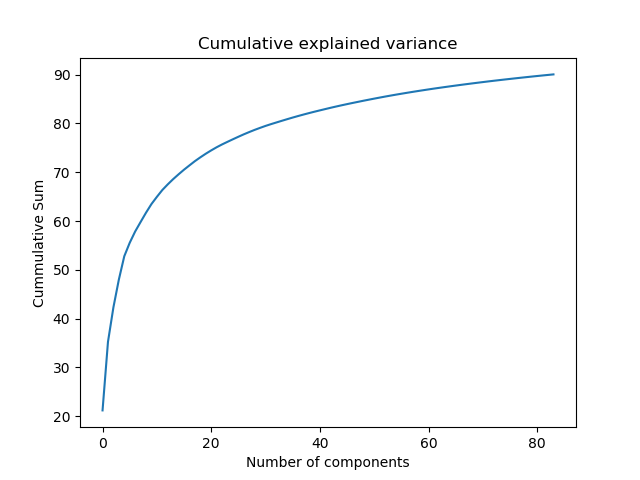

In [4]:
%matplotlib notebook
from sklearn import decomposition

pca = decomposition.PCA(n_components = 0.9, svd_solver = 'full')
pca.fit(train)

x = np.arange(0.0, pca.explained_variance_.size, 1.0)
y = pca.explained_variance_ratio_.cumsum() * 100

plt.plot(x, y)
plt.xlabel('Number of components')
plt.ylabel('Cummulative Sum')
plt.title('Cumulative explained variance')
plt.show()

Note how 50 components explain almost 90\% of the variance in the data. As such, it seems reasonable that we may rely only on those 50 components as features to represent our data. 

However, to clearly understand the implications of the adopted representation, you will now run an extensive test to investigate how the number of components may impact the performance of the classifier. 

---

#### Activity 3.        

Take the data in your training set and further split it in two sets, $D_T$ and $D_V$, where $D_T$ corresponds to $85\%$ of the training data and $D_V$ to the remaining $15\%$. You will use $D_T$ for training, and $D_V$ for validation. 

For $k\in\{10, 20, ..., 100\}$,

* Run PCA with $k$ components on the data in $D_T$
* Transform the data in $D_T$ using the computed PCA
* Train a logistic regression classifier on the transformed data, with $C=1000$
* Compute the error in $D_T$ and in $D_V$

Repeat the _whole process_ (including the split of $D_T$ and $D_V$) 30 times.

** Note: ** The whole process may take a while, so don't despair. The logistic classifier can be accessed by importing `LogisticRegression` from `sklearn.linear_model`. To compute the error of a classifier, you can use the `accuracy_score` function from `sklearn.metrics`.

---

In [37]:
from sklearn import linear_model
from sklearn import metrics

components = np.arange(10,110,10)
training_errors = np.zeros(components.shape[0])
validation_errors = np.zeros(components.shape[0])

for i in range(30):
    Dt, Dv, Dt_target, Dv_target = model_selection.train_test_split(train, train_target, test_size = 0.15, train_size = 0.85, random_state = 4)
    print(i)
    for k in components:
        print(str(k) + " components")
        pca = decomposition.PCA(n_components = k, svd_solver = 'full') #0.848
        
        pca.fit(Dt)
        Dt_transformed = pca.transform(Dt)
        Dv_transformed = pca.transform(Dv)
        
        logisticClassifier = linear_model.LogisticRegression(C=1000)
        
        logisticClassifier.fit(Dt_transformed, Dt_target)
        
        Dt_predicted = logisticClassifier.predict(Dt_transformed)
        Dv_predicted = logisticClassifier.predict(Dv_transformed)
        
        Dt_error = 1 - metrics.accuracy_score(Dt_target, Dt_predicted)
        Dv_error = 1 - metrics.accuracy_score(Dv_target, Dv_predicted)
        
        index = int(k/10)-1
        training_errors[index] += Dt_error
        validation_errors[index] += Dv_error

        print("Dt Error: " + str(Dt_error))
        print("Dv Error: " + str(Dv_error) + "\n")
        

0
10 components
Dt Error: 0.559094719195306
Dv Error: 0.6113744075829384

20 components
Dt Error: 0.366303436714166
Dv Error: 0.4218009478672986

30 components
Dt Error: 0.24308466051969824
Dv Error: 0.34123222748815163

40 components
Dt Error: 0.17854149203688185
Dv Error: 0.2890995260663507

50 components
Dt Error: 0.12070410729253978
Dv Error: 0.29383886255924174

60 components
Dt Error: 0.08968985750209557
Dv Error: 0.29383886255924174

70 components
Dt Error: 0.07041072925398151
Dv Error: 0.2654028436018957

80 components
Dt Error: 0.05448449287510482
Dv Error: 0.28436018957345977

90 components
Dt Error: 0.04610226320201172
Dv Error: 0.28436018957345977

100 components
Dt Error: 0.03688181056160944
Dv Error: 0.2985781990521327

1
10 components
Dt Error: 0.559094719195306
Dv Error: 0.6113744075829384

20 components
Dt Error: 0.366303436714166
Dv Error: 0.4218009478672986

30 components
Dt Error: 0.24308466051969824
Dv Error: 0.34123222748815163

40 components
Dt Error: 0.178541492

Dt Error: 0.559094719195306
Dv Error: 0.6113744075829384

20 components
Dt Error: 0.366303436714166
Dv Error: 0.4218009478672986

30 components
Dt Error: 0.24308466051969824
Dv Error: 0.34123222748815163

40 components
Dt Error: 0.17854149203688185
Dv Error: 0.2890995260663507

50 components
Dt Error: 0.12070410729253978
Dv Error: 0.29383886255924174

60 components
Dt Error: 0.08968985750209557
Dv Error: 0.29383886255924174

70 components
Dt Error: 0.07041072925398151
Dv Error: 0.2654028436018957

80 components
Dt Error: 0.05448449287510482
Dv Error: 0.28436018957345977

90 components
Dt Error: 0.04610226320201172
Dv Error: 0.28436018957345977

100 components
Dt Error: 0.03688181056160944
Dv Error: 0.2985781990521327

12
10 components
Dt Error: 0.559094719195306
Dv Error: 0.6113744075829384

20 components
Dt Error: 0.366303436714166
Dv Error: 0.4218009478672986

30 components
Dt Error: 0.24308466051969824
Dv Error: 0.34123222748815163

40 components
Dt Error: 0.17854149203688185
Dv Err

Dt Error: 0.559094719195306
Dv Error: 0.6113744075829384

20 components
Dt Error: 0.366303436714166
Dv Error: 0.4218009478672986

30 components
Dt Error: 0.24308466051969824
Dv Error: 0.34123222748815163

40 components
Dt Error: 0.17854149203688185
Dv Error: 0.2890995260663507

50 components
Dt Error: 0.12070410729253978
Dv Error: 0.29383886255924174

60 components
Dt Error: 0.08968985750209557
Dv Error: 0.29383886255924174

70 components
Dt Error: 0.07041072925398151
Dv Error: 0.2654028436018957

80 components
Dt Error: 0.05448449287510482
Dv Error: 0.28436018957345977

90 components
Dt Error: 0.04610226320201172
Dv Error: 0.28436018957345977

100 components
Dt Error: 0.03688181056160944
Dv Error: 0.2985781990521327

23
10 components
Dt Error: 0.559094719195306
Dv Error: 0.6113744075829384

20 components
Dt Error: 0.366303436714166
Dv Error: 0.4218009478672986

30 components
Dt Error: 0.24308466051969824
Dv Error: 0.34123222748815163

40 components
Dt Error: 0.17854149203688185
Dv Err

---

#### Activity 4.        

Plot the average training and validation error from Activity 3 as a function of $k$. Comment.

---

<IPython.core.display.Javascript object>


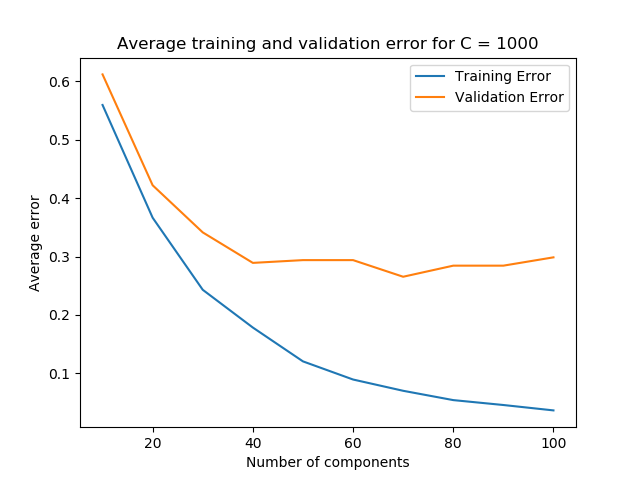

In [40]:
%matplotlib notebook

plt.plot(components, training_errors/30, label = "Training Error")
plt.plot(components, validation_errors/30, label = "Validation Error")

plt.xlabel('Number of components')
plt.ylabel('Average error')
plt.title('Average training and validation error for C = 1000')
plt.legend()
plt.show()

As seen in the homework, the logistic regression model is trained to minimize the cost function

$$J(\pi)=-\frac{1}{N}\sum_{n=1}^N\log(\pi(a_n\mid x_n)).$$

However, the logistic regression model in `scikit-learn` uses a slightly different cost function; this modified cost function includes a term that penalizes large values for the parameters $\mathbf{w}$ and takes the general form

$$J(\pi)=\frac{1}{2}\|w\|^2-\frac{C}{N}\sum_{n=1}^N\log(\pi(a_n\mid x_n)).$$

The first term is called a _regularization term_ and the constant $C$ expresses how much we are willing to pay (in terms of errors in the training set) to have small parameter vectors. In activity 3 you used a large value for $C$, indicating the algorithm that errors in the training set should be minimized.

---

#### Activity 5.

Repeat Activity 3 but now setting $C=1$. Plot the results and comment.

---

In [33]:
components = np.arange(10,110,10)
training_errors = np.zeros(components.shape[0])
validation_errors = np.zeros(components.shape[0])
logisticClassifier = linear_model.LogisticRegression(C=1)

for i in range(30):
    print(i)
    Dt, Dv, Dt_target, Dv_target = model_selection.train_test_split(train, train_target, test_size = 0.15, train_size = 0.85, random_state = 4)

    for k in components:
        print(str(k) + " components")
        pca = decomposition.PCA(n_components = k, svd_solver = 'full') #0.848
        
        pca.fit(Dt)
        Dt_transformed = pca.transform(Dt)
        Dv_transformed = pca.transform(Dv)
                
        logisticClassifier.fit(Dt_transformed, Dt_target)
        
        Dt_predicted = logisticClassifier.predict(Dt_transformed)
        Dv_predicted = logisticClassifier.predict(Dv_transformed)
        
        Dt_error = 1 - metrics.accuracy_score(Dt_target, Dt_predicted)
        Dv_error = 1 - metrics.accuracy_score(Dv_target, Dv_predicted)
        
        index = int(k/10)-1
        training_errors[index] += Dt_error
        validation_errors[index] += Dv_error

        print("Dt Error: " + str(Dt_error))
        print("Dv Error: " + str(Dv_error) + "\n") 


0
10 components
Dt Error: 0.5582564962279967
Dv Error: 0.5924170616113744

20 components
Dt Error: 0.3721709974853311
Dv Error: 0.4218009478672986

30 components
Dt Error: 0.24811399832355407
Dv Error: 0.3459715639810427

40 components
Dt Error: 0.18608549874266556
Dv Error: 0.28436018957345977

50 components
Dt Error: 0.1341156747694887
Dv Error: 0.2796208530805687

60 components
Dt Error: 0.10980720871751881
Dv Error: 0.26066350710900477

70 components
Dt Error: 0.09220452640402343
Dv Error: 0.2417061611374408

80 components
Dt Error: 0.07879295892707461
Dv Error: 0.2274881516587678

90 components
Dt Error: 0.0712489522212909
Dv Error: 0.2274881516587678

100 components
Dt Error: 0.055322715842414105
Dv Error: 0.23222748815165872

1
10 components
Dt Error: 0.5582564962279967
Dv Error: 0.5924170616113744

20 components
Dt Error: 0.3721709974853311
Dv Error: 0.4218009478672986

30 components
Dt Error: 0.24811399832355407
Dv Error: 0.3459715639810427

40 components
Dt Error: 0.186085498

Dt Error: 0.3721709974853311
Dv Error: 0.4218009478672986

30 components
Dt Error: 0.24811399832355407
Dv Error: 0.3459715639810427

40 components
Dt Error: 0.18608549874266556
Dv Error: 0.28436018957345977

50 components
Dt Error: 0.1341156747694887
Dv Error: 0.2796208530805687

60 components
Dt Error: 0.10980720871751881
Dv Error: 0.26066350710900477

70 components
Dt Error: 0.09220452640402343
Dv Error: 0.2417061611374408

80 components
Dt Error: 0.07879295892707461
Dv Error: 0.2274881516587678

90 components
Dt Error: 0.0712489522212909
Dv Error: 0.2274881516587678

100 components
Dt Error: 0.055322715842414105
Dv Error: 0.23222748815165872

12
10 components
Dt Error: 0.5582564962279967
Dv Error: 0.5924170616113744

20 components
Dt Error: 0.3721709974853311
Dv Error: 0.4218009478672986

30 components
Dt Error: 0.24811399832355407
Dv Error: 0.3459715639810427

40 components
Dt Error: 0.18608549874266556
Dv Error: 0.28436018957345977

50 components
Dt Error: 0.1341156747694887
Dv Er

Dt Error: 0.24811399832355407
Dv Error: 0.3459715639810427

40 components
Dt Error: 0.18608549874266556
Dv Error: 0.28436018957345977

50 components
Dt Error: 0.1341156747694887
Dv Error: 0.2796208530805687

60 components
Dt Error: 0.10980720871751881
Dv Error: 0.26066350710900477

70 components
Dt Error: 0.09220452640402343
Dv Error: 0.2417061611374408

80 components
Dt Error: 0.07879295892707461
Dv Error: 0.2274881516587678

90 components
Dt Error: 0.0712489522212909
Dv Error: 0.2274881516587678

100 components
Dt Error: 0.055322715842414105
Dv Error: 0.23222748815165872

23
10 components
Dt Error: 0.5582564962279967
Dv Error: 0.5924170616113744

20 components
Dt Error: 0.3721709974853311
Dv Error: 0.4218009478672986

30 components
Dt Error: 0.24811399832355407
Dv Error: 0.3459715639810427

40 components
Dt Error: 0.18608549874266556
Dv Error: 0.28436018957345977

50 components
Dt Error: 0.1341156747694887
Dv Error: 0.2796208530805687

60 components
Dt Error: 0.10980720871751881
Dv E

<IPython.core.display.Javascript object>


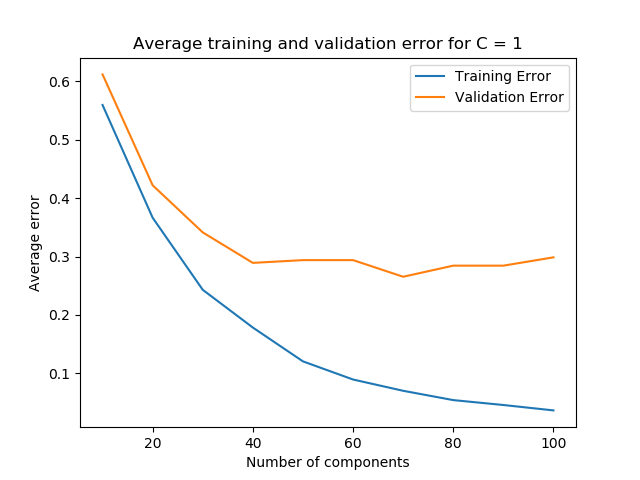

Enquanto que para C=1 o erro no validation set pára , com C=1000 esse valor fica próximo dos 0.1% .Conclui-se então que com para um menor valor de C, o classificador consegue melhor performance no validation test, evitando assim overfit.


In [41]:
%matplotlib notebook

plt.plot(components, training_errors/30, label = "Training Error")
plt.plot(components, validation_errors/30, label = "Validation Error")

plt.xlabel('Number of components')
plt.ylabel('Average error')
plt.title('Average training and validation error for C = 1')
plt.legend()
plt.show()

print("Enquanto que para C=1 o erro no validation set pára perto dos 30%, com C=1000 esse valor fica próximo dos 10% ."\
     "Conclui-se então que com para um menor valor de C, o classificador consegue melhor performance no validation test, "\
     "evitando assim overfit.")

In light of the results, we can now safely train our classifier with a larger number of components (say, $k=80$) by setting $C=1$ to avoid overfitting.

---

#### Activity 6.

* Retrain your PCA model with $k=80$ components---now using all your training data;
* Retrain the logistic regression model;
* Compute the performance of the resulting model in the test data (don't forget to transform the test data).

In particular, compute both the accuracy score and print the confusion matrix (which you can access from `sklearn.metrics`). Comment the obtained results in face of Activities 3-5.

---

In [47]:
pca = decomposition.PCA(n_components = 80)
logisticClassifier = linear_model.LogisticRegression(C=1)

pca.fit(train)

train_transformed = pca.transform(train)
test_transformed = pca.transform(test)

logisticClassifier.fit(train_transformed,train_target)

train_predicted = logisticClassifier.predict(train_transformed)
test_predicted = logisticClassifier.predict(test_transformed)

train_accuracy = metrics.accuracy_score(train_predicted,train_target)
test_accuracy = metrics.accuracy_score(test_predicted,test_target)

print("Train accuracy score: " + str(train_accuracy))
print("Test accuracy score: " + str(test_accuracy))
print("Confusion matrix:")
print(metrics.confusion_matrix(test_target, test_predicted))
print("Os valores obtidos vão de acordo com o previamente calculado, mostrando uma accuracy superior à atividade 3 mas inferior à atividade 5."\
      "Podemos concluir portanto que nem sempre uma maior amostra de dados nos providencia melhor resultados, "\
     "pois há maior probalidade de overfit ao training set. ")
print("Através da confusion matrix, é possível verificar quem o modelo confude com quem. Nota-se que a figura 1 é a mais confudida com os demais.")

Train accuracy score: 0.9138176638176638
Test accuracy score: 0.7948717948717948
Confusion matrix:
[[ 6  2  0  0  3  0  0  2  1  0  0  0]
 [ 0 16  0  1  0  1  0  0  0  0  0  3]
 [ 0  0  8  1  0  0  0  0  0  0  0  1]
 [ 0  1  0 45  0  0  0  0  0  1  0  0]
 [ 0  0  1  1  7  1  0  1  0  0  0  0]
 [ 0  1  0  0  0  5  0  0  1  0  1  0]
 [ 0  1  0  1  2  0  3  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  7  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  6  0]
 [ 0  0  0  2  0  0  0  0  0  0  0 12]]
Os valores obtidos vão de acordo com o previamente calculado, mostrando uma accuracy superior à atividade 3 mas inferior à atividade 5.Podemos concluir portanto que nem sempre uma maior amostra de dados nos providencia melhor resultados, pois há maior probalidade de overfit ao training set. 
Através da confusion matrix, é possível verificar quem o modelo confude com quem. Nota-se que a figura 1 é a mais confudida com os demais.
